# U ResNet for 5 particle segmentation

In this notebook, I set up and train UResNet for 5 particle classification on the DeepLearnPhysics open data sets.

In [22]:
BATCH_SIZE = 4
NUM_LABELS = 6 # (background, electron, muon, photon, pion, proton)
N_INITIAL_FILTERS = 32
NETWORK_DEPTH = 4


## Looking at the data

First things first, let's take a look at the data.  We'll use the larcv dataloader2 functionality to open up the data and look at it, similar to [this blog post](http://deeplearnphysics.org/Blog/2018-01-05-TrainingSegmentationData_v0.1.0.html#2018-01-05-TrainingSegmentationData_v0.1.0 "DeepLearnPhysics Blog: Semantic Segmentation")

In [1]:
import ROOT
from larcv import larcv
larcv.ThreadProcessor
from larcv.dataloader2 import larcv_threadio
import numpy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys,time

# tensorflow/gpu start-up configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
import tensorflow as tf



Welcome to JupyROOT 6.08/06
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


Get an instance of the train data loader to load some images:

In [2]:
# Dump the contents of the config file:
with open('train_io.cfg', 'r') as f:
    s = ""
    for line in f.readlines(): 
        s += line
    print s

TrainIO: {
  Verbosity:       3
  EnableFilter:    false
  RandomAccess:    2
  RandomSeed:      0
  InputFiles:      ["/data/LARTPC_INDP/practice_train_2k.root"]
  ProcessType:     ["Cluster2DThreshold","MultiPartSegFromCluster2dParticle","BatchFillerImage2D","BatchFillerImage2D"]
  ProcessName:     ["Cluster2DThreshold","MultiPartSegFromCluster2dParticle","main_data","main_label"]
  NumThreads:      1
  NumBatchStorage: 1

  ProcessList: {
    main_data: {
      Verbosity: 3
      ImageProducer: "data"
      Channels: [0]
    }
    main_label: {
      Verbosity: 3
      ImageProducer: "mcst_multip"
      Channels: [0]
    }
    Cluster2DThreshold: {
      Cluster2DProducer:  "mcst"
      OutputProducer:     "mcst_threshold"
      Threshold:          0.2
    }
    MultiPartSegFromCluster2dParticle: {
      Cluster2dProducer: "mcst_threshold"
      OutputProducer:    "mcst_multip"
      ParticleProducer:  "mcst"
      Image2dProducer:   "data"
      PdgClassList:      [11,-11,13,-13,22

In [3]:
train_io = larcv_threadio()
train_io_cfg = {'filler_name' : 'TrainIO',
                'verbosity'   : 0, 
                'filler_cfg'  : 'train_io.cfg'}
train_io.configure(train_io_cfg)

 setting verbosity 3


For just looking at the data, start the manager with just one event:

In [4]:
train_io.start_manager(1)


Fetch some data so we can look at it:

In [5]:
data = train_io.fetch_data('main_data')
label = train_io.fetch_data('main_label')

In [14]:
print "Data dimensions: {}".format(data.dim())
print "Label dimensions: {}".format(label.dim())

Data dimensions: [  1 256 256   1]
Label dimensions: [  1 256 256   1]


Let's visualize these images:

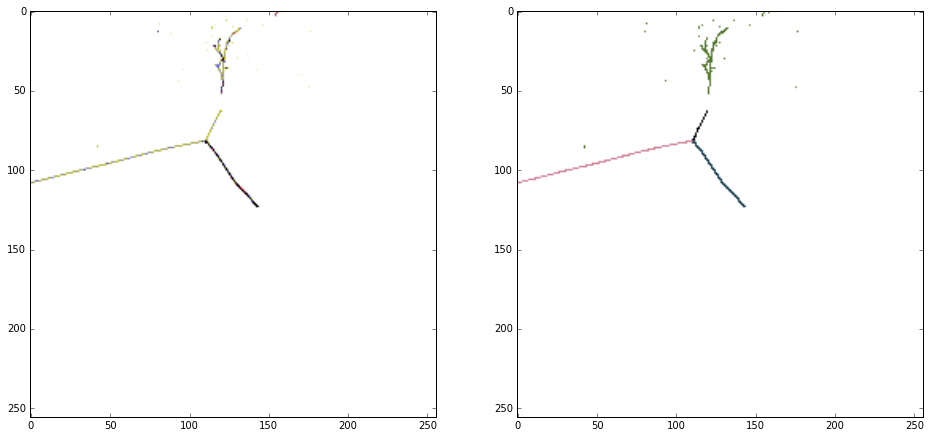

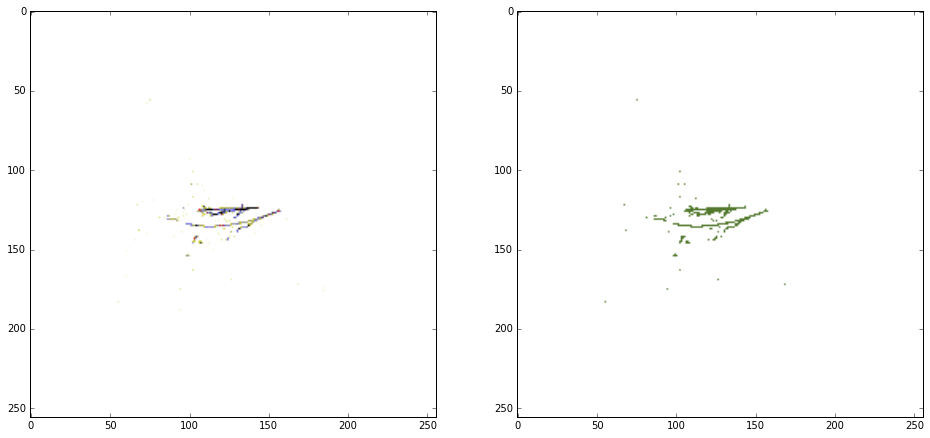

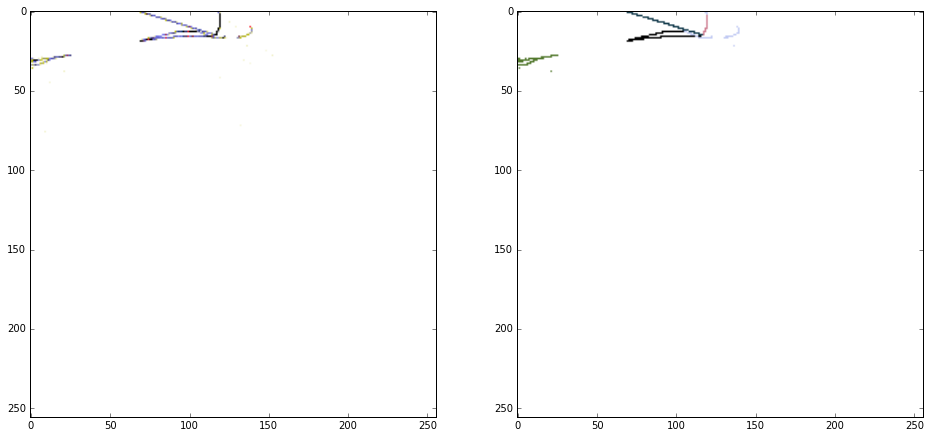

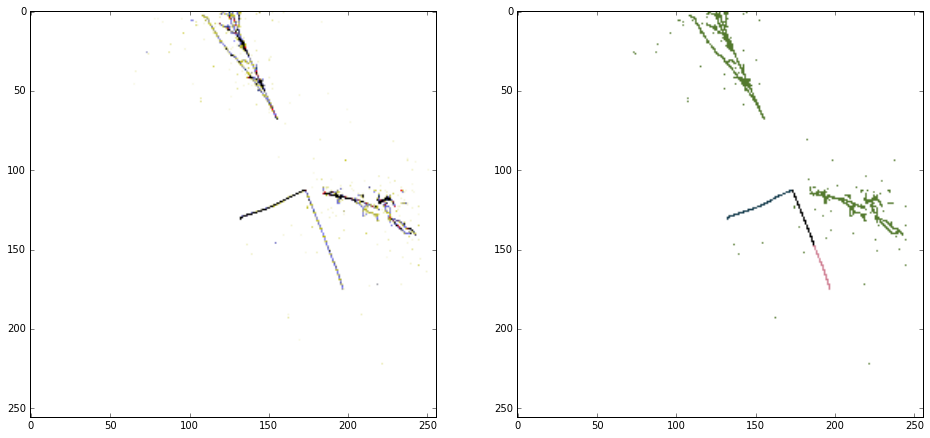

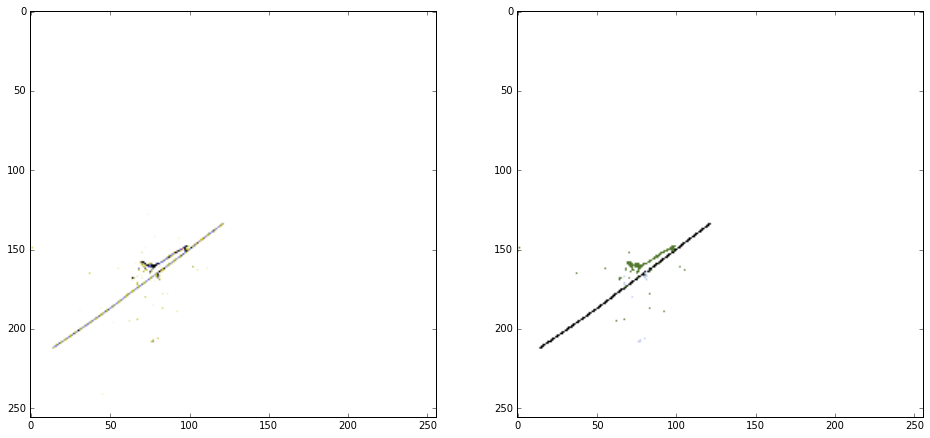

In [7]:
for i in xrange(5):
    # Load new data:
    train_io.next()

    while train_io.is_reading():
        time.sleep(0.1)

    # Fetch the data and reshape it:
    plt_data   = numpy.reshape(train_io.fetch_data("main_data").data(), (256, 256))
    label_arr = numpy.reshape(train_io.fetch_data("main_label").data(), (256, 256))

    f, axarr = plt.subplots(1,2, figsize=(16, 8))
    axarr[0].imshow(plt_data, vmin=0, vmax=300, cmap='gist_stern_r')
    axarr[1].imshow(label_arr,vmin=0, vmax=5, cmap='cubehelix_r')

    plt.show()


## Setting up a network

From the images above, you can get a sense of the task to come.  We'll use a residual version of UNet for this, and there are useful functions defined in the utils class for implementing this:

In [8]:
from utils import residual_block, downsample_block, upsample_block

The first step of set up is to define placeholders for the input:

In [18]:
def init_inputs(graph, device, data, label):
    with graph.as_default(), tf.device(device):
        input_image  = tf.placeholder(tf.float32, data.dim(), name="input_image")
        input_labels = tf.placeholder(tf.float32, label.dim(), name="input_image")
        
        # Convert the labels to one-hot format:
        labels_onehot = tf.one_hot(depth=NUM_LABELS, indices = input_labels)

In [20]:
# Next, make the network graph intialization:

In [24]:
def build_network(graph, device, input_image, training):
    with graph.as_default, tf.device(device):
        
        x = input_image
        
        # Initial convolution to get to the correct number of filters:
        x = tf.layers.conv2d_transpose(x, n_filters,
                             kernel_size=[5, 5],
                             strides=[1, 1],
                             padding='same',
                             use_bias=False,
                             trainable=is_training,
                             name="Conv2DInitial",
                             reuse=None)

        # ReLU:
        x = tf.nn.relu(x)
        
        # Need to keep track of the outputs of the residual blocks before downsampling, to feed 
        # On the upsampling side
        
        network_filters = []
        network_filters.append(x)

        # Begin the process of residual blocks and downsampling:
        for i in xrange(NETWORK_DEPTH):
            
            x = residual_block(x, training,
                               batch_norm=False,
                               name="resblock_down_{0}".format(i))
        
            network_filters.append(x)
            x = downsample_block(x, training,
                                batch_norm=False,
                                name="downsample_{0}".format(i))
        
        
        # At the bottom, do another residual block:
        x = residual_block(x, training, batch_norm=False, name="deepest_block")
        
        # Come back up the network:
        for i in xrange(NETWORK_DEPTH-1, -1, -1):
            
            # How many filters to return from upsampling?
            n_filters = x.get_shape().as_list()[-1]
            
            x = tf.concatenate([x, network_filters[-1]], axis=-1, name='up_concat_{}'.format(i))
            
            # Remove the recently concated filters:
            network_filters.pop()
            
            # Upsample:
            x = upsample_block(x, training, batch_norm=False,n_output_filters=n_filters, name="upsample_{}".format(i))
            
            # Residual
            x = residual_block(x, training,
                               batch_norm=False,
                               name="resblock_down_{0}".format(i))
        
        # At this point, we ought to have a network that has the same shape as the initial input, but with more filters.
        # We can use a bottleneck to map it onto the right dimensions:
        x = tf.layers.conv2d(x,
                             NUM_LABELS,
                             strides=[1, 1],
                             padding='same',
                             activation=None,
                             use_bias=False,
                             trainable=is_training,
                             name="Conv2D",
                             reuse=None)
        
        # The final activation is softmax across the pixels:
        